<a href="https://colab.research.google.com/github/shubham8garg/nlp/blob/master/Variational_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder

###### An autoencoder is a type of neural network which learns to copy its input to its output. Encoder encodes the image into compressed representation, and decoder decodes the representation.

Data for this project is downloaded from: https://www.kaggle.com/oddrationale/mnist-in-csv/version/2

In [1]:
!pip install numpy matplotlib pandas torch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [7]:
data = pd.read_csv('/content/drive/MyDrive/Colab/VAE/mnist_data/mnist_train.csv')

In [8]:
data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,1x11,1x12,1x13,1x14,1x15,1x16,1x17,1x18,1x19,1x20,1x21,1x22,1x23,1x24,1x25,1x26,1x27,1x28,2x1,2x2,2x3,2x4,2x5,2x6,2x7,2x8,2x9,2x10,2x11,...,27x17,27x18,27x19,27x20,27x21,27x22,27x23,27x24,27x25,27x26,27x27,27x28,28x1,28x2,28x3,28x4,28x5,28x6,28x7,28x8,28x9,28x10,28x11,28x12,28x13,28x14,28x15,28x16,28x17,28x18,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,147,252,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Each image which is represented as each row here in the data is a 1-Dimensional representation of 784 pixels.
Let's convert each image to 2-D representation of 28X28 shape.

In [13]:
train_label = data[['label']].copy()
train_data = data.drop('label', 1)

In [14]:
train_data.shape

(60000, 784)

In [16]:
train_data.head()

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,1x11,1x12,1x13,1x14,1x15,1x16,1x17,1x18,1x19,1x20,1x21,1x22,1x23,1x24,1x25,1x26,1x27,1x28,2x1,2x2,2x3,2x4,2x5,2x6,2x7,2x8,2x9,2x10,2x11,2x12,...,27x17,27x18,27x19,27x20,27x21,27x22,27x23,27x24,27x25,27x26,27x27,27x28,28x1,28x2,28x3,28x4,28x5,28x6,28x7,28x8,28x9,28x10,28x11,28x12,28x13,28x14,28x15,28x16,28x17,28x18,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,147,252,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


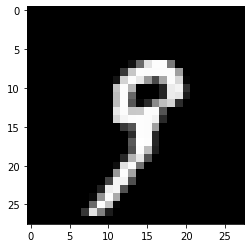

In [20]:
image = train_data.iloc[19] #selecting image at index3
image = np.array(image).astype('float32')
image = np.reshape(image, (28,28)) #reshaping
image = image / 255 #scaling to pixel between 0 to 1
plt.imshow(image, cmap='gray')

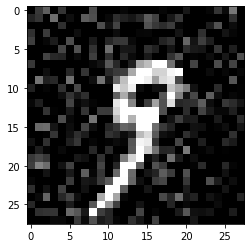

In [21]:
noisy_image = image + 0.2 * np.random.randn(*image.shape)
noisy_image = np.clip(noisy_image, 0,1)
plt.imshow(noisy_image, cmap='gray')

We need to perform this method for each datapoint which will be a cumbersome task. So we will create a class/function which will take input as one index and give the correct image and noisy image.

In [23]:
!cp /content/drive/MyDrive/Colab/VAE/helper.py .

In [24]:
from torch.utils.data import Dataset
from helper import show_image, ToTensorForAE

In [35]:
class MNIST_Dataset(Dataset):

  def __init__(self, csv_file, transform=None, noise_factor = 0.2):
    self.data = pd.read_csv(csv_file)
    self.noise_factor = noise_factor
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image = self.data.iloc[idx] #selecting image at index3
    image = np.array(image)
    image = np.reshape(image, (28,28)) #reshaping
    image = image / 255 #scaling to pixel between 0 to 1
    
    noisy_image = image + self.noise_factor * np.random.randn(*image.shape)
    noisy_image = np.clip(noisy_image, 0,1)

    sample = (noisy_image, image)
    
    if self.transform:
      sample = self.transform(sample)

    return sample

In [38]:
class MNIST_AE_Dataset(Dataset):
    
    def __init__(self,csv_file,noise_factor = 0.2,transform = None):
        
        self.data = pd.read_csv(csv_file)
        self.transform = transform 
        self.noise_factor = noise_factor
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        
        img = self.data.iloc[idx]
        img = np.array(img)
        img = np.reshape(img,(28,28,1)) / 255
        
        noisy_img = img + self.noise_factor * np.random.randn(*img.shape)
        noisy_img = np.clip(noisy_img,0.,1.)
        
        sample = (noisy_img,img)
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

Transform in the dataset class is used to transform the data into required format.
For example, ToTensorforAE() is a custome transform which will convert numpy PIL image to torch tensor and it will convert image with (height, width, channel) to (channel, height, width) as per pytorch model input convention.

In [39]:
trainset = MNIST_AE_Dataset('/content/drive/MyDrive/Colab/VAE/mnist_dataset.csv', transform=ToTensorForAE())

In [40]:
print('Size of trainset: {}'.format(len(trainset)))

Size of trainset: 42000


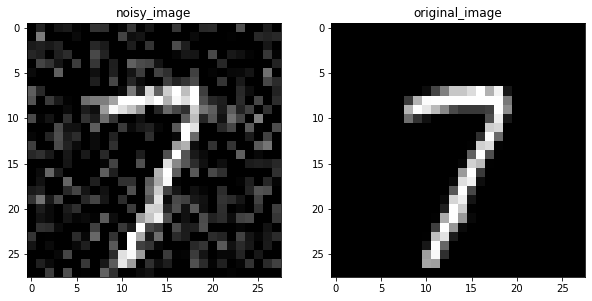

In [41]:
noisy_img, orig_img = trainset[18]
show_image(noisy_img, orig_img)

## Load dataset into batches


In [43]:
from torch.utils.data import DataLoader

In [44]:
trainloader = DataLoader(trainset, batch_size=16, shuffle=True)

In [45]:
dataiter = iter(trainloader)
noisy_img, orig_img = dataiter.next()

print("Shape of loading one batch: {}".format(noisy_img.shape))
print("Total number of batches: {}".format(len(trainloader)))
print("Total number of examples: {}".format(len(trainloader.dataset)))

Shape of loading one batch: torch.Size([16, 1, 28, 28])
Total number of batches: 2625
Total number of examples: 42000
